In [1]:
import os
from dotenv import load_dotenv
import chainlit as cl
from langchain_openai.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langgraph.prebuilt import ToolExecutor
from langchain_core.messages import HumanMessage
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage

load_dotenv()

# Your existing code for setting up the LangGraph components
# (Include all the necessary imports and function definitions)

# Set model variables
# OPENAI_BASE_URL = "https://api.openai.com/v1"
# OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
# OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")

# Initialize LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_PROJECT"] = "Demos"


# ### Import the prompts dictionary
from libs.prompts import prompts

# Define the get_prompt function to retrieve prompts from the dictionary
def get_prompt(prompts, name):
    return prompts.get(name, f"Prompt with name '{name}' not found.")

# Use the get_prompt function to retrieve the desired prompts
system_prompt_sentinel_EDA = get_prompt(prompts, "system_prompt_memory_sentinel_EDA")
system_prompt_memory_manager = get_prompt(prompts, "system_prompt_memory_manager_EDA")


2024-08-03 22:33:02 - Loaded .env file


In [2]:
# ### Set up Agent: Memory Sentinel


from langchain_openai.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.runnables import RunnablePassthrough



# Get the prompt to use - you can modify this!
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(system_prompt_sentinel_EDA),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Remember, only respond with TRUE or FALSE. Do not provide any other information.",
        ),
    ]
)


# Choose the LLM that will drive the agent
llm = ChatOpenAI(
    
    model="gpt-4o-mini",
    streaming=True,
    temperature=0.0,
)

sentinel_runnable = {"messages": RunnablePassthrough()} | prompt | llm



In [3]:

# ### Set up Agent: Memory Manager


from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool
from enum import Enum
from typing import Optional

class Category(str, Enum):
    BASICS = "basics"
    VARIABLES = "variables"
    DATA_QUALITY = "data_quality"
    ANALYSES = "analyses"
    VISUALIZATIONS = "visualizations"
    INSIGHTS = "insights"
    NEXT_STEPS = "next_steps"

class Action(str, Enum):
    ADD = "add"
    UPDATE = "update"
    DELETE = "delete"

class AddKnowledge(BaseModel):
    knowledge: str = Field(
        ...,
        description="Condensed bit of information about the dataset or EDA progress to be saved or updated (e.g., 'Dataset has 1956111 rows and 8 columns', 'Correlation analysis performed between EDA_raw and medicationIntake')",
    )
    knowledge_old: Optional[str] = Field(
        None,
        description="If updating or deleting, the complete, exact phrase that needs to be modified",
    )
    category: Category = Field(
        ..., description="Category that this information belongs to"
    )
    action: Action = Field(
        ...,
        description="Whether this information is adding a new record, updating a record, or deleting a record",
    )

import json

def modify_knowledge(
    knowledge: str,
    category: Category,
    action: Action,
    knowledge_old: str = "",
) -> dict:
    print(f"Modifying Dataset Description: {action} {category} - {knowledge}")
    if knowledge_old:
        print(f"Old information: {knowledge_old}")
    
    # Load existing memories
    try:
        with open(MEMORY_FILE, 'r') as f:
            memories = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        memories = []
    
    # Modify memories based on action
    if action == Action.ADD:
        memories.append({"category": category, "knowledge": knowledge})
    elif action == Action.UPDATE:
        for item in memories:
            if item["knowledge"] == knowledge_old:
                item["knowledge"] = knowledge
                break
    elif action == Action.DELETE:
        memories = [item for item in memories if item["knowledge"] != knowledge_old]
    
    # Save updated memories
    with open(MEMORY_FILE, 'w') as f:
        json.dump(memories, f)
    
    return {"updated_memories": [item["knowledge"] for item in memories]}

tool_modify_knowledge = StructuredTool.from_function(
    func=modify_knowledge,
    name="Knowledge_Modifier",
    description="Add, update, or delete information in the dataset description",
    args_schema=AddKnowledge,
)

# Set up the tools to execute them from the graph
from langgraph.prebuilt import ToolExecutor

# Set up the agent's tools
agent_tools = [tool_modify_knowledge]

tool_executor = ToolExecutor(agent_tools)


from langchain_openai.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.utils.function_calling import convert_to_openai_function


# Get the prompt to use - you can modify this!
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(system_prompt_memory_manager),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Choose the LLM that will drive the agent
llm = ChatOpenAI(
    # model="gpt-3.5-turbo-0125",
    model="gpt-4o",
    streaming=True,
    temperature=0.0,
)

# Create the tools to bind to the model
tools = [convert_to_openai_function(t) for t in agent_tools]

knowledge_master_runnable = prompt | llm.bind_tools(tools)


In [4]:

# ### Set up the Graph


from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    # The list of previous messages in the conversation
    messages: Sequence[BaseMessage]
    # The long-term memories to remember
    memories: Sequence[str]
    # Whether the information is relevant
    contains_information: str


import json
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolInvocation


def call_sentinel(state):
    messages = state["messages"]
    response = sentinel_runnable.invoke(messages)
    return {"contains_information": "TRUE" in response.content and "yes" or "no"}


# Define the function that determines whether to continue or not
def should_continue(state):
    last_message = state["messages"][-1]
    # If there are no tool calls, then we finish
    if "tool_calls" not in last_message.additional_kwargs:
        return "end"
    # Otherwise, we continue
    else:
        return "continue"


# Define the function that calls the knowledge master
def call_knowledge_master(state):
    messages = state["messages"]
    memories = state["memories"]
    response = knowledge_master_runnable.invoke(
        {"messages": messages, "memories": memories}
    )
    return {"messages": messages + [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    memories = state["memories"]
    last_message = messages[-1]

    new_memories = []
    for tool_call in last_message.additional_kwargs["tool_calls"]:
        action = ToolInvocation(
            tool=tool_call["function"]["name"],
            tool_input=json.loads(tool_call["function"]["arguments"]),
            id=tool_call["id"],
        )

        response = tool_executor.invoke(action)
        function_message = ToolMessage(
            content=str(response), name=action.tool, tool_call_id=tool_call["id"]
        )

        messages.append(function_message)
        if isinstance(response, dict) and "updated_memories" in response:
            new_memories.extend(response["updated_memories"])

    return {"messages": messages, "memories": memories + new_memories}


In [5]:

from langgraph.graph import StateGraph, END

# Initialize a new graph
graph = StateGraph(AgentState)

# Define the two "Nodes"" we will cycle between
graph.add_node("sentinel", call_sentinel)
graph.add_node("knowledge_master", call_knowledge_master)
graph.add_node("action", call_tool)

# Define all our Edges

# Set the Starting Edge
graph.set_entry_point("sentinel")

# We now add Conditional Edges
graph.add_conditional_edges(
    "sentinel",
    lambda x: x["contains_information"],
    {
        "yes": "knowledge_master",
        "no": END,
    },
)
graph.add_conditional_edges(
    "knowledge_master",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

# We now add Normal Edges that should always be called after another
graph.add_edge("action", END)

# We compile the entire workflow as a runnable
app = graph.compile()



In [7]:
!pip install pygraphviz

  Using cached pygraphviz-1.13.tar.gz (104 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.13-cp310-cp310-linux_x86_64.whl size=168498 sha256=035c273530b39c4260697492c376f562ddf220d2a54dbfe73fe423bf459897e4
  Stored in directory: /home/fd/.cache/pip/wheels/c5/96/10/6c25add1fffc368b1927252bf73b63fcb938de8f4486e23691
Successfully built pygraphviz


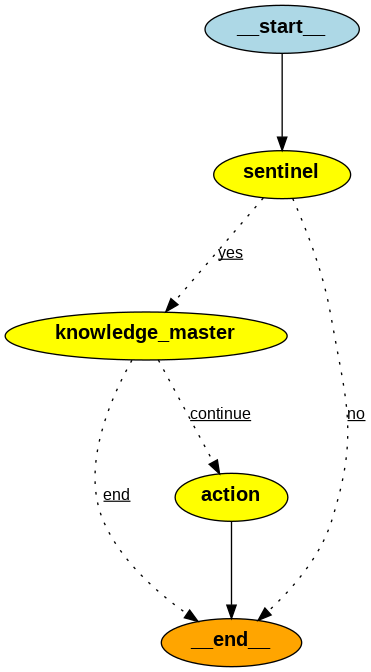

In [8]:
from IPython.display import Image, display


display(Image(app.get_graph().draw_png()))

In [ ]:
### CHAINLIT CONFIGURATION
import os
import chainlit as cl
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig

import json

MEMORY_FILE = "memories.json"

def load_memories():
    try:
        with open(MEMORY_FILE, 'r') as f:
            memories = json.load(f)
        return [item["knowledge"] for item in memories]
    except (FileNotFoundError, json.JSONDecodeError):
        return []

async def display_memories(memories):
    memory_text = "\n".join(memories) if memories else "No memories saved."
    await cl.Message(content=f"## Saved Memories\n\n{memory_text}").send()

@cl.on_chat_start
async def start():
    memories = load_memories()
    cl.user_session.set("memories", memories)
    await display_memories(memories)

@cl.on_message
async def run_conversation(message: cl.Message):
    memories = load_memories()  # Always load the latest memories from file
    
    inputs = AgentState(
        messages=[HumanMessage(content=message.content)],
        memories=memories,
        contains_information=""
    )
    
    config = RunnableConfig(
        callbacks=[
            cl.LangchainCallbackHandler(
                stream_final_answer=True,
                to_ignore=["ChannelRead", "RunnableLambda", "ChannelWrite", "__start__", "_execute"]
            )
        ]
    )
    
    result = app.invoke(inputs, config=config)
    
    # The memories are now managed by the modify_knowledge function,
    # so we don't need to update them here.
    
    final_message = result["messages"][-1]
    await cl.Message(content=final_message.content).send()

    if "tool_calls" in final_message.additional_kwargs:
        for tool_call in final_message.additional_kwargs["tool_calls"]:
            await cl.Message(
                content=f"Tool used: {tool_call['function']['name']}\n"
                        f"Input: {tool_call['function']['arguments']}"
            ).send()
    
    # Display updated memories after each interaction
    updated_memories = load_memories()
    await display_memories(updated_memories)

